In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.stats import norm

from copy import deepcopy
import itertools
import random

from collections import OrderedDict


import torch
import torch.nn as nn


from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
from ses_network_3_0 import SESNetwork
#from extraction_works.ses_network_2_0_copy import SESNetwork
from utils import make_input, LatentSpace, get_sample_from_num_swaps, get_cos_sim_np, get_cos_sim_torch, test_network, get_ordered_weights

In [1]:
network_parameters = {}

network_parameters["hebbian_filter"] = False

network_parameters["duration_phase_A"] = 1000
network_parameters["duration_phase_B"] = 1500

network_parameters["sleep_duration_A"] = 10
network_parameters["sleep_duration_B"] = 10
network_parameters["reset_dayly"] = True

network_parameters["regions"] = ["sen", "mtl_sparse", "mtl_dense", "mtl", "ctx"]

network_parameters["mtl_pattern_complete_iterations"] = 10
network_parameters["mtl_dense_pattern_complete_iterations"] = 10
network_parameters["mtl_sparse_pattern_complete_iterations"] = 10
network_parameters["ctx_pattern_complete_iterations"] = 10
network_parameters["mtl_generate_pattern_complete_iterations"] = 10

network_parameters["max_semantic_charge"] = 2

network_parameters["sen_num_subregions"] = 1
network_parameters["sen_size_subregions"] = torch.tensor([100])
network_parameters["sen_sparsity"] = torch.tensor([0.2])
network_parameters["sen_sparsity_sleep"] = torch.tensor([0.2])

network_parameters["ctx_num_subregions"] = 2
network_parameters["ctx_size_subregions"] =  torch.tensor([100, 250])
network_parameters["ctx_sparsity"] = torch.tensor([0.2, 1/25])
network_parameters["ctx_sparsity_sleep"] = torch.tensor([0.1, 1/25])

network_parameters["mtl_num_subregions"] = 2
network_parameters["mtl_size_subregions"] =  torch.tensor([100, 100])
network_parameters["mtl_sparsity"] = torch.tensor([0.2, 0.1])
network_parameters["mtl_sparsity_sleep"] = torch.tensor([0.1, 0.05])

network_parameters["mtl_dense_num_subregions"] = 1
network_parameters["mtl_dense_size_subregions"] = torch.tensor([100])
network_parameters["mtl_dense_sparsity"] = torch.tensor([0.2])
network_parameters["mtl_dense_sparsity_sleep"] = torch.tensor([0.1])

network_parameters["mtl_sparse_num_subregions"] = 1
network_parameters["mtl_sparse_size_subregions"] = torch.tensor([100])
network_parameters["mtl_sparse_sparsity"] = torch.tensor([0.1])
network_parameters["mtl_sparse_sparsity_sleep"] = torch.tensor([0.05])

network_parameters["mtl_dense_sen_projection"] = True
network_parameters["mtl_dense_sen_sparsity"] = 0.5
network_parameters["mtl_dense_sen_size"] = 30
network_parameters["max_post_mtl_dense_sen"] = 1
network_parameters["max_pre_mtl_dense_sen"] = np.inf


network_parameters["ctx_mtl_quick_lmbda"] = 1e-2
network_parameters["max_pre_ctx_mtl_quick"] = np.inf
network_parameters["max_post_ctx_mtl_quick"] = 1

network_parameters["ctx_mtl_sparsity"] = 0.5
network_parameters["ctx_mtl_mean"] = 0.04
network_parameters["ctx_mtl_std"] = 0.005
network_parameters["ctx_mtl_lmbda"] = 5e-4
network_parameters["ctx_mtl_size"] = 2
network_parameters["max_pre_ctx_mtl"] = np.inf
network_parameters["max_post_ctx_mtl"] = 1

network_parameters["ctx_mtl_sparse_mean"] = 0.07
network_parameters["ctx_mtl_sparse_std"] = 0.001
network_parameters["ctx_mtl_sparse_lmbda"] = 5e-4
network_parameters["max_pre_ctx_mtl_sparse"] = np.inf
network_parameters["max_post_ctx_mtl_sparse"] = 1

network_parameters["ctx_mtl_dense_sparsity"] = 0.5
network_parameters["ctx_mtl_dense_g"] = 0.01

network_parameters["mtl_mtl_lmbda"] = 5e-3
network_parameters["max_pre_mtl_mtl"] = np.inf
network_parameters["max_post_mtl_mtl"] = np.inf

network_parameters["mtl_dense_mtl_dense_lmbda"] = 5e-3
network_parameters["max_pre_mtl_dense_mtl_dense"] = np.inf
network_parameters["max_post_mtl_dense_mtl_dense"] = np.inf

network_parameters["mtl_sparse_mtl_sparse_lmbda"] = 5e-3
network_parameters["max_pre_mtl_sparse_mtl_sparse"] = np.inf
network_parameters["max_post_mtl_sparse_mtl_sparse"] = np.inf

network_parameters["ctx_ctx_sparsity"] = 0.05
network_parameters["ctx_ctx_g"] = 1e-4
network_parameters["ctx_ctx_lmbda"] = 5e-4
network_parameters["max_pre_ctx_ctx"] = 1
network_parameters["max_post_ctx_ctx"] = np.inf

network_parameters["mtl_sparse_ctx_mean"] = 0.03
network_parameters["mtl_sparse_ctx_std"] = 0.001
network_parameters["mtl_sparse_ctx_lmbda"] = 5e-3
network_parameters["max_pre_mtl_sparse_ctx"] = np.inf
network_parameters["max_post_mtl_sparse_ctx"] = 1


recording_parameters = {}
recording_parameters["regions"] = ["sen", "mtl_hat", "mtl_dense", "mtl_sparse", "mtl_sparse_hat", "mtl", "ctx", "ctx_hat"]
recording_parameters["rate_activity"] = 1
#recording_parameters["connections"] = ["mtl_mtl", "ctx_mtl", "ctx_ctx", "ctx_mtl_quick", "mtl_sparse_ctx"]
recording_parameters["connections"] = ["mtl_sparse_mtl_sparse"]
recording_parameters["rate_connectivity"] = 1

NameError: name 'torch' is not defined

In [137]:
input_params = {}
input_params["num_days"] = 100
input_params["day_length"] = 100
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 8

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]

'''
latent_specs["num"] = 5
latent_specs["total_sizes"] = [20, 20, 20, 20, 20]
latent_specs["act_sizes"] = [10, 10, 10, 10, 10]
latent_specs["dims"] = [2, 2, 2, 2, 2]
'''

'\nlatent_specs["num"] = 5\nlatent_specs["total_sizes"] = [20, 20, 20, 20, 20]\nlatent_specs["act_sizes"] = [10, 10, 10, 10, 10]\nlatent_specs["dims"] = [2, 2, 2, 2, 2]\n'

In [138]:
def test_network(net, input_params, print_rate=1):
  input, input_episodes, input_latents = make_input(**input_params)
  with torch.no_grad():
    for day in range(input_params["num_days"]):
      if day%print_rate == 0:
        print(day)
      net(input[day], debug=False)
      net.sleep()
  return input, input_episodes, input_latents, net

In [139]:
latent_specs["prob_list"] = [0.2 if i==0 else 0 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)
network = SESNetwork(network_parameters, recording_parameters)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

for k in range(1, 5):
    latent_specs["prob_list"] = [0.2 if i==k else 0 for i in range(5) for j in range(5)]
    input_params["latent_space"] = LatentSpace(**latent_specs)
    input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

0
50
0
50
0
50
0
50
0
50


In [140]:
session_length = input_params["num_days"] * input_params["day_length"]

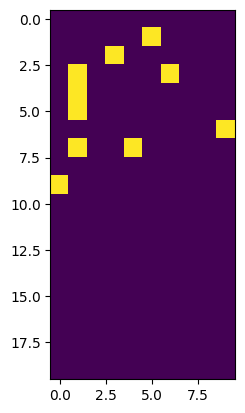

In [146]:
plt.imshow(torch.stack(network.activity_recordings["mtl"],dim=0)[network.sleep_indices_A][10].reshape(-1, 10))

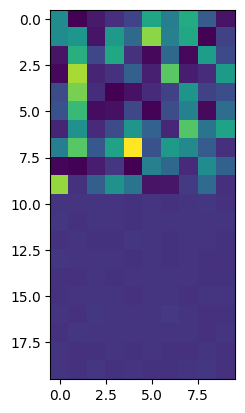

In [144]:
session = 0
plt.imshow(torch.stack(network.activity_recordings["mtl"],dim=0)[network.awake_indices][session*session_length:(session+1)*session_length].mean(dim=0).reshape(-1, 10))

In [ ]:
def plot_ctx_selectivity():
    #obtain average mtl activity for each session
    #obtain average mtl activity across sessions
    #obtain average mtl activity during replay
    #obtain average dot product replay activity vs mtl activity

In [110]:
latent_specs["prob_list"] = [0.2 if i==0 else 0 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)
network = SESNetwork(network_parameters, recording_parameters)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

0


KeyboardInterrupt: 

In [100]:
latent_specs["prob_list"] = [0.2 if i==2 else 0 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

0
50


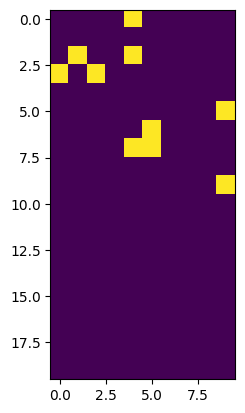

In [20]:
plt.imshow(torch.stack(network.activity_recordings["mtl"],dim=0)[network.sleep_indices_A][-1].reshape(-1, 10))

In [25]:
torch.stack(network.activity_recordings["mtl"],dim=0)[network.awake_indices].shape

torch.Size([8000, 200])

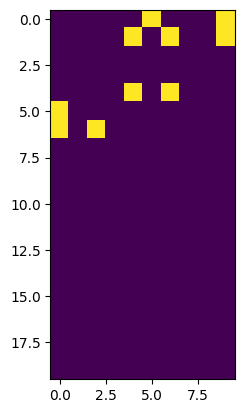

In [30]:
plt.imshow(torch.stack(network.activity_recordings["mtl"],dim=0)[network.sleep_indices_A][-1].reshape(-1, 10))

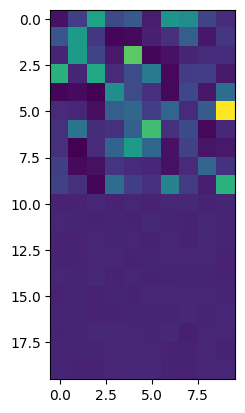

In [31]:
plt.imshow(torch.stack(network.activity_recordings["mtl"],dim=0)[network.awake_indices][:4000].mean(dim=0).reshape(-1, 10))

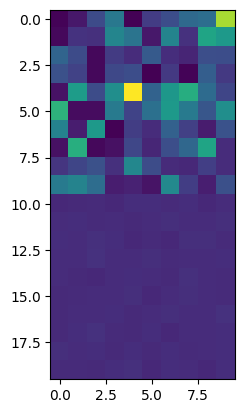

In [29]:
plt.imshow(torch.stack(network.activity_recordings["mtl"],dim=0)[network.awake_indices][4000:].mean(dim=0).reshape(-1, 10))

plt.imshow(torch.stack(network.activity_recordings["mtl"],dim=0)[network.awake_indices][4000:].mean(dim=0).reshape(-1, 10))

In [104]:
latent_specs["prob_list"] = [0.2 if i==4 else 0 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

0
50


In [119]:
latent_specs["prob_list"] = [0.2 if i==0 else 0 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)
network = SESNetwork(network_parameters, recording_parameters)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

for k in range(1, 5):
    latent_specs["prob_list"] = [0.2 if i==k else 0 for i in range(5) for j in range(5)]
    input_params["latent_space"] = LatentSpace(**latent_specs)
    input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

for k in range(5):
    latent_specs["prob_list"] = [0.2 if j==k else 0 for i in range(5) for j in range(5)]
    input_params["latent_space"] = LatentSpace(**latent_specs)
    input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)


#torch.save(network, "network.pt")

0
50
0
50
0
50


KeyboardInterrupt: 

In [7]:
#latent_specs["prob_list"] = [0.05 if i==j else 0.05/9 for i in range(10) for j in range(10)]
#latent_specs["prob_list"] = [1/100 for i in range(10) for j in range(10)]
#latent_specs["prob_list"] = [1/32 for i in range(32)]

latent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
#latent_specs["prob_list"] = [0.1 if i==j else 0.1/4 for i in range(5) for j in range(5)]

#latent_specs["prob_list"] = [0.2 if j==4 else 0 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)
#network = SESNetwork(network_parameters, recording_parameters)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)
#torch.save(network, "network.pt")

0
50


(array([ 4.,  9., 22., 55., 88., 80., 51., 28., 12.,  1.]),
 array([0.35396725, 0.36319661, 0.372426  , 0.3816554 , 0.39088476,
        0.40011412, 0.40934351, 0.4185729 , 0.42780226, 0.43703163,
        0.44626102]),
 <BarContainer object of 10 artists>)

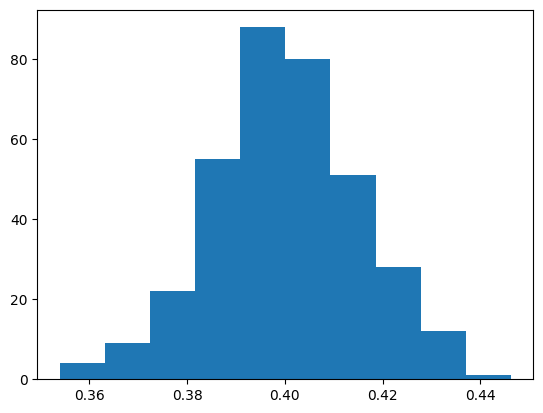

In [102]:
plt.hist(torch.stack(network.activity_recordings["ctx_hat"], dim=0)[network.sleep_indices_A][0].flatten())

(array([ 10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,  22., 116.,
        146.,  38.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,  10.]),
 array([0.        , 0.018     , 0.036     , 0.054     , 0.072     ,
        0.09      , 0.108     , 0.126     , 0.14399999, 0.162     ,
        0.17999999, 0.198     , 0.21599999, 0.234     , 0.252     ,
        0.26999998, 0.28799999, 0.30599999, 0.324     , 0.34199998,
        0.35999998, 0.37799999, 0.396     , 0.41399997, 0.43199998,
        0.44999999, 0.46799999, 0.486     , 0.50400001, 0.52200001,
        0.53999996, 0.55799997, 0.57599998, 0.59399998, 0.61199999,
        0.63      , 0.648     , 0.66600001, 0.68399996, 0.70199996,
        0.71999997, 0.73799998, 0.75599998, 0.77399999, 0.792     ,
        0.81      , 0.82799995, 0.84599996, 0.

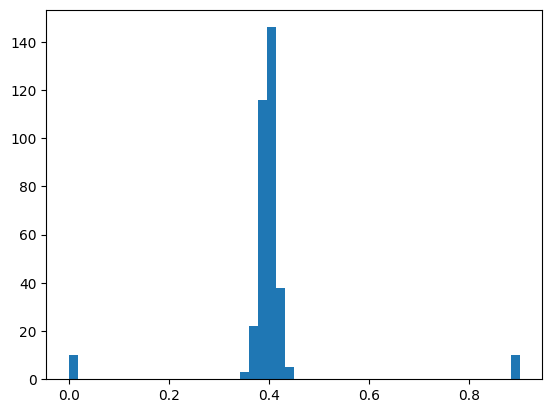

In [108]:
plt.hist(torch.stack(network.activity_recordings["ctx_hat"], dim=0)[network.sleep_indices_A][4].flatten(), bins=50)

(array([ 10.,   0.,   0.,   0., 330.,   0.,   5.,   0.,   0.,   5.]),
 array([0.20049872, 0.26034936, 0.3202    , 0.38005063, 0.43990126,
        0.4997519 , 0.55960256, 0.61945319, 0.67930382, 0.73915446,
        0.79900509]),
 <BarContainer object of 10 artists>)

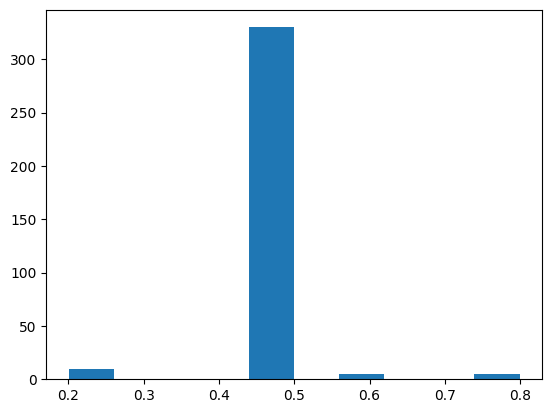

In [ ]:
plt.hist(torch.stack(network.activity_recordings["ctx_hat"], dim=0)[network.sleep_indices_A][11].flatten())

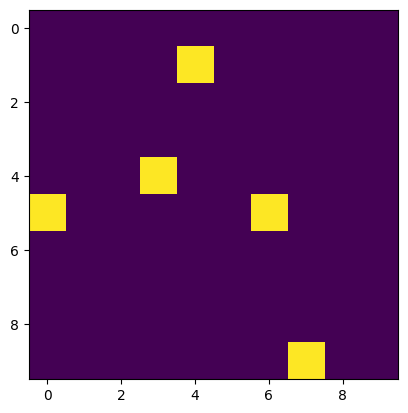

In [159]:
plt.imshow(torch.stack(network.activity_recordings["mtl_dense"], dim=0)[network.sleep_indices_A][0].reshape((-1, 10)))

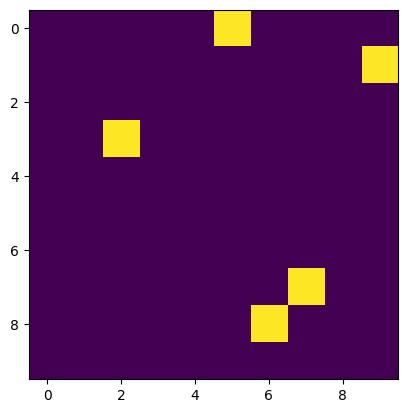

In [160]:
plt.imshow(torch.stack(network.activity_recordings["mtl_dense"], dim=0)[network.sleep_indices_A][1].reshape((-1, 10)))

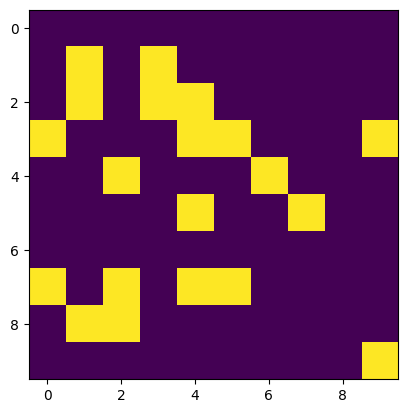

In [161]:
plt.imshow(torch.stack(network.activity_recordings["mtl_dense"], dim=0)[network.awake_indices][1].reshape((-1, 10)))

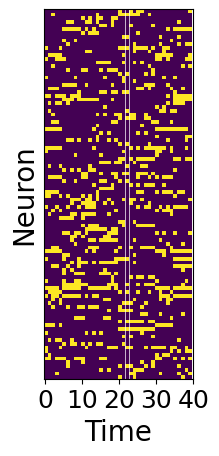

In [325]:
plt.imshow(torch.stack(network.activity_recordings["mtl_dense"], dim=0)[network.awake_indices][-40:].reshape((-1, 100)).T)
plt.yticks([])
plt.xticks([0, 10, 20, 30, 40], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time", fontsize=20)
plt.axvline(21.5, lw=0.5, color='white')
plt.axvline(22.5, lw=0.5, color='white')

In [37]:
input_latents

tensor([[[1, 3],
         [1, 3],
         [1, 3],
         [1, 3],
         [1, 3],
         [3, 3],
         [3, 3],
         [3, 3],
         [3, 3],
         [3, 3],
         [0, 1],
         [0, 1],
         [0, 1],
         [0, 1],
         [0, 1],
         [3, 3],
         [3, 3],
         [3, 3],
         [3, 3],
         [3, 3],
         [4, 0],
         [4, 0],
         [4, 0],
         [4, 0],
         [4, 0],
         [2, 3],
         [2, 3],
         [2, 3],
         [2, 3],
         [2, 3],
         [3, 4],
         [3, 4],
         [3, 4],
         [3, 4],
         [3, 4],
         [0, 3],
         [0, 3],
         [0, 3],
         [0, 3],
         [0, 3]]], dtype=torch.int32)

(array([345.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   5.]),
 array([0.14343053, 0.20908748, 0.27474442, 0.34040138, 0.40605831,
        0.47171527, 0.53737223, 0.60302919, 0.66868609, 0.73434305,
        0.80000001]),
 <BarContainer object of 10 artists>)

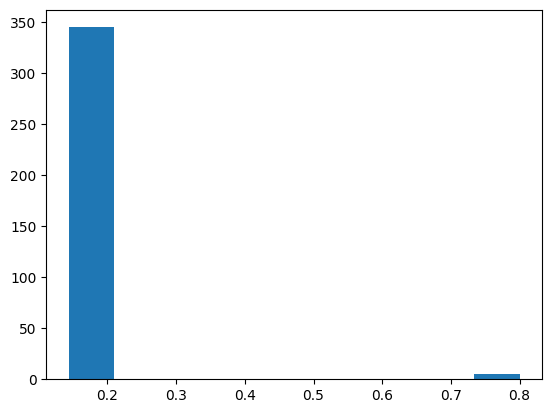

In [20]:
plt.hist(torch.stack(network.activity_recordings["ctx_hat"], dim=0)[network.sleep_indices_A][1].flatten())

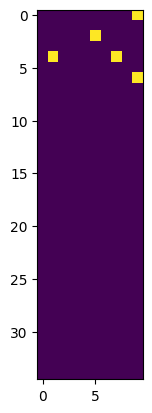

In [59]:
plt.imshow(torch.stack(network.activity_recordings["ctx"], dim=0)[network.sleep_indices_A][0].reshape((-1, 10)))

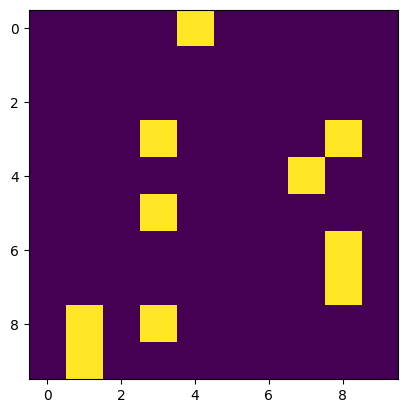

In [20]:
plt.imshow(torch.stack(network.activity_recordings["mtl_dense"], dim=0)[network.sleep_indices_A][0].reshape((-1, 10)))

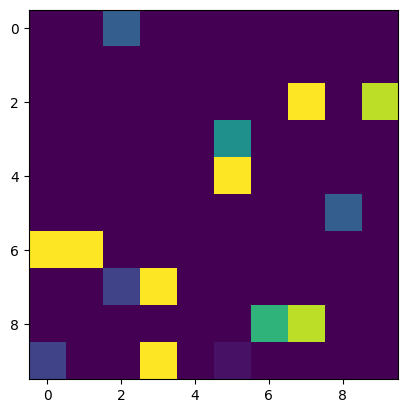

In [208]:
plt.imshow(torch.stack(network.activity_recordings["mtl_dense"], dim=0)[network.sleep_indices_A].mean(axis=0).reshape((-1, 10)))

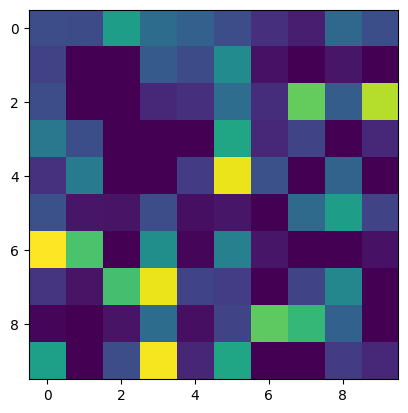

In [209]:
plt.imshow(torch.stack(network.activity_recordings["mtl_dense"], dim=0)[network.awake_indices].mean(axis=0).reshape((-1, 10)))

(array([51.,  9., 13.,  3.,  9.,  4.,  3.,  5.,  1.,  2.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

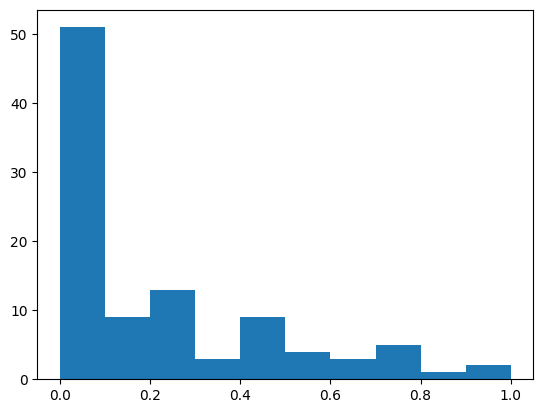

In [176]:
plt.hist(torch.stack(network.activity_recordings["mtl_dense"], dim=0)[network.awake_indices].mean(axis=0).flatten())

(array([ 9., 19., 15.,  6., 14.,  9., 12.,  4.,  6.,  6.]),
 array([0.0229954 , 0.11629674, 0.20959808, 0.30289942, 0.39620075,
        0.4895021 , 0.58280343, 0.67610478, 0.76940614, 0.86270744,
        0.95600879]),
 <BarContainer object of 10 artists>)

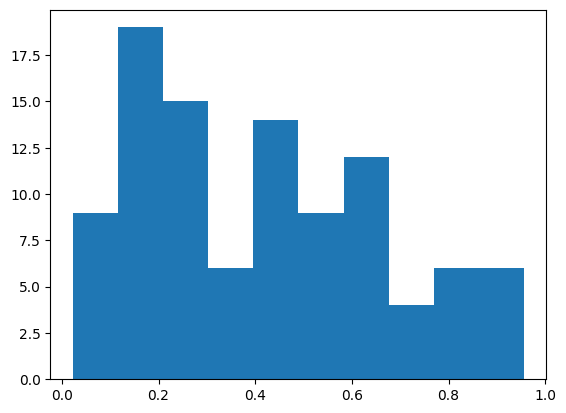

In [35]:
plt.hist(torch.stack(network.activity_recordings["mtl_dense"], dim=0).mean(axis=0).flatten())

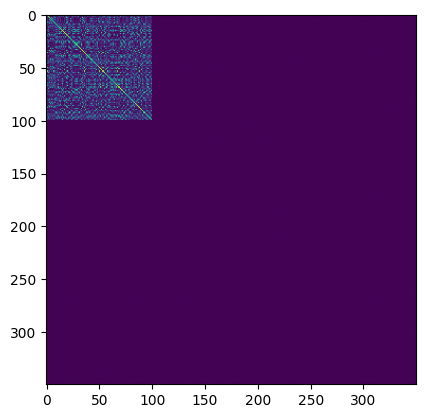

In [41]:
plt.imshow(network.ctx_ctx)

In [76]:
X_ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]

X_latent_A = F.one_hot(input_latents[-100:, :, 0].long(), num_classes=latent_specs["dims"][0])
X_latent_B = F.one_hot(input_latents[-100:, :, 1].long(), num_classes=latent_specs["dims"][1])
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=2)

In [77]:
# Flatten time
days, day_length, num_latents = X_latent_AB.shape
_, num_neurons = X_ctx.shape

latents_flat = X_latent_AB.reshape(-1, num_latents).float()    # shape: (days * day_length, num_latents)
neurons_ctx_flat = X_ctx.reshape(-1, num_neurons).float()    # shape: (days * day_length, num_neurons)

# Normalize (zero mean, unit variance)
latents_norm = (latents_flat - latents_flat.mean(dim=0)) / latents_flat.std(dim=0)
neurons_ctx_norm = (neurons_ctx_flat - neurons_ctx_flat.mean(dim=0)) / neurons_ctx_flat.std(dim=0)


# Compute correlation (selectivity): (num_neurons, num_latents)
selectivity_ctx = neurons_ctx_norm.T @ latents_norm / latents_norm.shape[0]

In [78]:
threshold = 0.6
num_neurons, num_latents = selectivity_ctx.shape

# Identify the latent with the highest selectivity per neuron
max_selectivity, max_latent_idx = selectivity_ctx.max(dim=1)

# Assign neurons to latents if selectivity >= threshold, else assign -1 (non-selective)
assigned_latents = torch.where(max_selectivity >= threshold, max_latent_idx, -1)

# Generate reordered indices
ordered_indices = []

# Iterate over each latent to collect selective neurons
for latent in range(num_latents):
    latent_neurons = (assigned_latents == latent).nonzero(as_tuple=True)[0]
    ordered_indices.append(latent_neurons)

# Add non-selective neurons at the end
non_selective_neurons = (assigned_latents == -1).nonzero(as_tuple=True)[0]
ordered_indices.append(non_selective_neurons)

# Concatenate indices into a single ordering
ordered_indices = torch.cat(ordered_indices)


([], [])

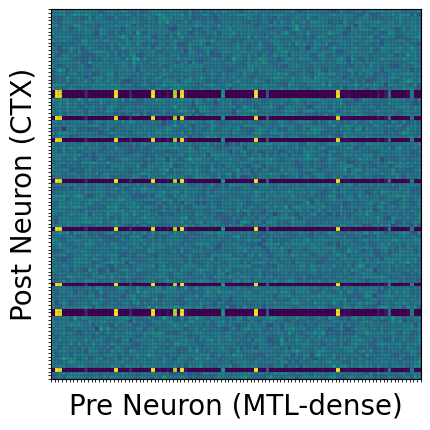

In [79]:
plt.imshow(network.ctx_mtl[ordered_indices[:100], :100])
plt.ylabel("Post Neuron (CTX)", fontsize=20)
plt.xlabel("Pre Neuron (MTL-dense)", fontsize=20)

plt.xticks(np.arange(-0.5, 100, 1), minor=True)
plt.yticks(np.arange(-0.5, 100, 1), minor=True)
plt.grid(which='minor', color='black', linestyle='-', linewidth=0.1)
plt.xticks([])
plt.yticks([])

Text(0.5, 0, 'Pre Neuron (CTX)')

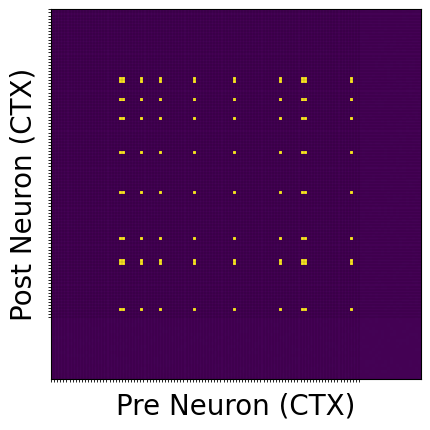

In [80]:
plt.imshow(network.ctx_ctx[ordered_indices[:120]][:, ordered_indices[:120]])
plt.xticks(np.arange(-0.5, 100, 1), minor=True)
plt.yticks(np.arange(-0.5, 100, 1), minor=True)
plt.grid(which='minor', color='black', linestyle='-', linewidth=0.1)
plt.xticks([])
plt.yticks([])

plt.ylabel("Post Neuron (CTX)", fontsize=20)
plt.xlabel("Pre Neuron (CTX)", fontsize=20)

(array([ 368.,  859., 1931.,  225.,   17.,    0.,    0.,    0.,   10.,
          90.]),
 array([-0.27123427, -0.15210254, -0.03297081,  0.08616092,  0.20529266,
         0.32442439,  0.44355613,  0.56268787,  0.68181956,  0.8009513 ,
         0.92008305]),
 <BarContainer object of 10 artists>)

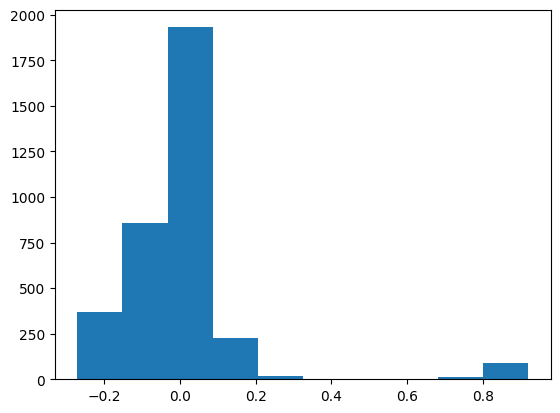

In [427]:
plt.hist(selectivity_ctx.flatten())

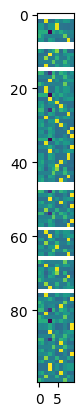

In [97]:
plt.imshow(selectivity_ctx[:100])

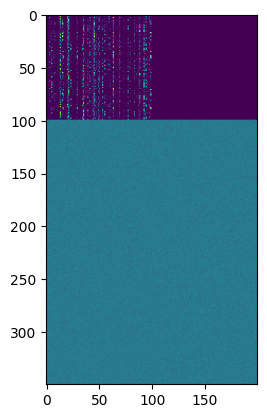

In [192]:
plt.imshow(network.ctx_mtl)

In [120]:
_, order_ctx_ctx, w_ctx_ctx = get_ordered_weights(network.ctx_ctx, order_columns=True)
_, order_mtl_sparse_ctx_A, w_mtl_sparse_ctx = get_ordered_weights(network.mtl_sparse_ctx)
_, order_mtl_sparse_ctx_B, w_mtl_sparse_ctx = get_ordered_weights(w_mtl_sparse_ctx.T)
_, order_mtl_sparse_ctx_C, w_mtl_sparse_ctx = get_ordered_weights(w_mtl_sparse_ctx.T)
_, order_ctx_mtl, w_ctx_mtl = get_ordered_weights(network.ctx_mtl)

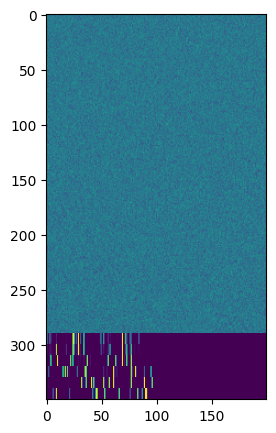

In [121]:
fig = plt.figure(figsize=((5, 5)))
plt.imshow(w_ctx_mtl)

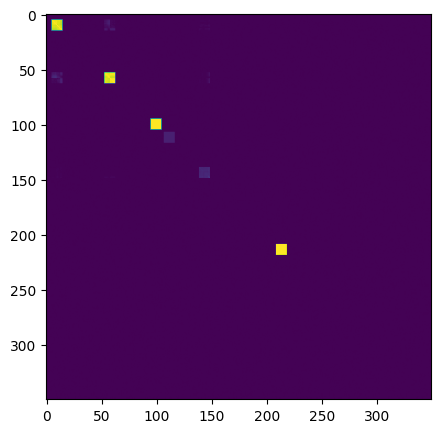

In [122]:
fig = plt.figure(figsize=((5, 5)))
plt.imshow(w_ctx_ctx)

(array([ 1.,  1., 92.,  3.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([0.99999428, 0.99999636, 0.99999845, 1.0000006 , 1.00000262,
        1.00000477, 1.00000691, 1.00000894, 1.00001109, 1.00001311,
        1.00001526]),
 <BarContainer object of 10 artists>)

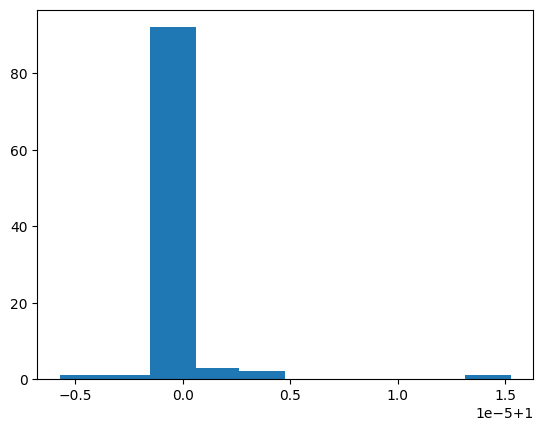

In [21]:
plt.hist(network.mtl_dense_sen.sum(axis=1))

In [8]:
w_network.homeostasis('mtl_dense', 'sen')

(array([ 2.,  4., 14., 18., 18., 22., 17.,  3.,  1.,  1.]),
 array([-18.06502151, -14.61641693, -11.16781235,  -7.71920824,
         -4.27060413,  -0.82199955,   2.6266048 ,   6.07520914,
          9.52381325,  12.97241783,  16.42102242]),
 <BarContainer object of 10 artists>)

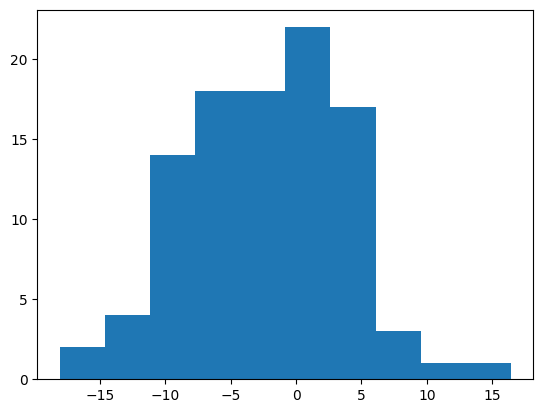

In [10]:
plt.hist(network.mtl_dense_sen.sum(axis=0))

In [51]:
w_plastic = network.mtl_dense_sen_plastic.clone()
w_fixed = network.mtl_dense_sen_fixed.clone()
w = network.mtl_dense_sen.clone()

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  2.,  0.,  6.,  9., 39., 24.,  7.,  2.,  5.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-8.59289551, -8.20344257, -7.81398964, -7.42453623, -7.03508329,
        -6.64563036, -6.25617743, -5.86672401, -5.47727108, -5.08781815,
        -4.69836521, -4.3089118 , -3.91945887, -3.53000593, -3.14055276,
        -2.75109982, -2.36164665, -1.97219372, -1.58274066, -1.19328761,
        -0.80383456, -0.41438147, -0.02492844,  0.3645246 ,  0.75397766,
         1.14343071,  1.53288376,  1.92233682,  2.31178975,  2.70124292,
         3.09069586,  3.48014903,  3.86960196,  4.25905514,  4.64850807,
         5.03796101,  5.42741442,  5.81686735,  6.20632029,  6.59577322,
         6.98522663,  7.37467957,  7.7641325 ,  8.15358543,  8.54303837,
         8.9324913 ,  9.32194519,  9.71139812, 10.10085106,

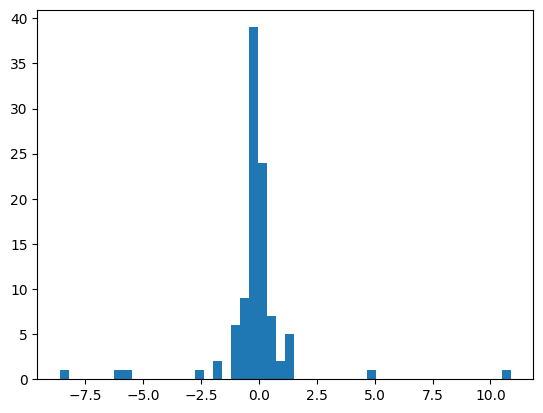

In [53]:
plt.hist(post_scaling_factors.flatten(), bins=50)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 2.000e+00, 4.000e+00, 4.000e+00, 6.000e+00,
        6.000e+00, 6.000e+00, 1.000e+00, 7.000e+00, 1.100e+01, 1.600e+01,
        1.800e+01, 4.000e+01, 1.090e+02, 7.870e+02, 8.615e+03, 2.070e+02,
        4.600e+01, 2.200e+01, 1.500e+01, 1.300e+01, 1.000e+01, 8.000e+00,
        5.000e+00, 5.000e+00, 4.000e+00, 7.000e+00, 2.000e+00, 4.000e+00,
        3.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-28.46282387, -27.45342064, -26.44401741, -25.43461227,
        -24.42520905, -23.41580582, -22.40640259, -21.39699936,
        -20.38759422, -19.37819099, -18.36878777, -17.35938454,
        -16.34998131, -15.34057713, -14.33117294, -13.32176971,
        -12.31236649, -11.3029623 , -10.29355907,  -9.28415489,
         -8.27475166,  -7.26534796,  -6.25594425,  -5.24

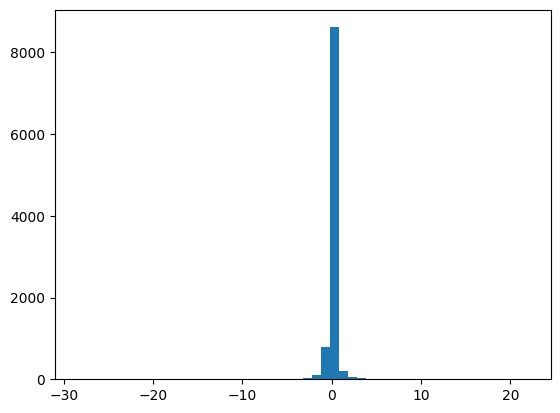

In [54]:
plt.hist(w_plastic.flatten(), bins=50)

(array([ 2.,  0.,  0., 40., 56.,  0.,  1.,  0.,  0.,  1.]),
 array([0.99999619, 0.99999714, 0.99999809, 0.99999905, 1.        ,
        1.00000095, 1.00000191, 1.00000286, 1.00000381, 1.00000477,
        1.00000572]),
 <BarContainer object of 10 artists>)

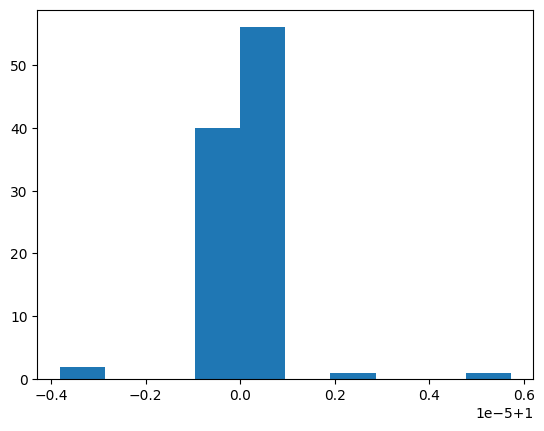

In [57]:
plt.hist(w_plastic.sum(axis=1), bins=10)

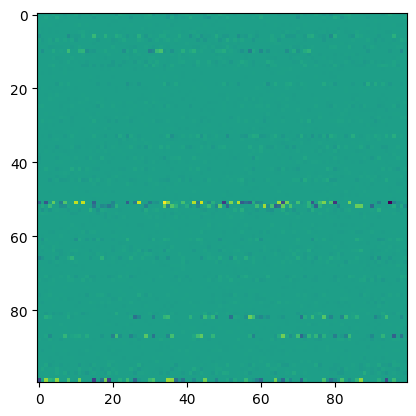

In [58]:
plt.imshow(w_plastic)